<li> id – Atua como uma chave exclusiva para cada anúncio nos dados do aplicativo</li>
<li>nome - Representa o nome do anúncio</li>
<li>host_id - Representa o id do usuário que hospedou o anúncio</li>
<li>host_name – Contém o nome do usuário que hospedou o anúncio</li>
<li>bairro_group - Contém o nome do bairro onde o anúncio está localizado</li>
<li>bairro - Contém o nome da área onde o anúncio está localizado</li>
<li>latitude - Contém a latitude do local</li>
<li>longitude - Contém a longitude do local</li>
<li>room_type – Contém o tipo de espaço de cada anúncio</li>
<li>price - Contém o preço por noite em dólares listado pelo anfitrião</li>
<li>minimo_noites - Contém o número mínimo de noites que o usuário deve reservar</li>
<li>numero_de_reviews - Contém o número de comentários dados a cada listagem</li>
<li>ultima_review - Contém a data da última revisão dada à listagem</li>
<li>reviews_por_mes - Contém o número de avaliações fornecidas por mês</li>
<li>calculado_host_listings_count - Contém a quantidade de listagem por host</li>
<li>disponibilidade_365 - Contém o número de dias em que o anúncio está disponível para reserva</li>


In [221]:
#Import libraries
import numpy as np
import pandas as pd
import json

#Visual libraries
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
#Import csv file
path = 'https://raw.githubusercontent.com/DenisePotenza/Indicium/main/teste_indicium_precificacao.csv'
ny_rent = pd.read_csv(path, parse_dates=['ultima_review'])

#Show first five rows
ny_rent.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaT,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


In [3]:
#Dataset shape
print(f'Temos {ny_rent.shape[0]} linhas e {ny_rent.shape[1]} colunas no conjunto de dados.')

Temos 48894 linhas e 16 colunas no conjunto de dados.


In [4]:
#Dataset info
ny_rent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   id                             48894 non-null  int64         
 1   nome                           48878 non-null  object        
 2   host_id                        48894 non-null  int64         
 3   host_name                      48873 non-null  object        
 4   bairro_group                   48894 non-null  object        
 5   bairro                         48894 non-null  object        
 6   latitude                       48894 non-null  float64       
 7   longitude                      48894 non-null  float64       
 8   room_type                      48894 non-null  object        
 9   price                          48894 non-null  int64         
 10  minimo_noites                  48894 non-null  int64         
 11  numero_de_revie

In [5]:
#Missing data per column
((ny_rent.isnull().sum() / len(ny_rent)) * 100).sort_values(ascending=False)

ultima_review                    20.558760
reviews_por_mes                  20.558760
host_name                         0.042950
nome                              0.032724
id                                0.000000
host_id                           0.000000
bairro_group                      0.000000
bairro                            0.000000
latitude                          0.000000
longitude                         0.000000
room_type                         0.000000
price                             0.000000
minimo_noites                     0.000000
numero_de_reviews                 0.000000
calculado_host_listings_count     0.000000
disponibilidade_365               0.000000
dtype: float64

Temos quatro colunas com dados faltando, sendo ultima_review e reviews_por_mes com mais de 20% de entradas vazias.

In [6]:
#Numeric and categorical culumns
numeric = ["int16", "int32", "int64", "float16", "float32", "float64"]

#All numeric columns
numericas = ny_rent.select_dtypes(include=numeric)

#All categorical columns
categoricas = ny_rent.select_dtypes(exclude=numeric)

print(f"Temos {numericas.shape[1]} colunas numéricas e {categoricas.shape[1]} colunas categoricas.")


Temos 10 colunas numéricas e 6 colunas categoricas.


In [7]:
#Describe
ny_rent.describe().T

,count,mean,min,25%,50%,75%,max,std
id,48894.0,19017532.130609,2595.0,9472370.75,19677431.5,29152249.25,36487245.0,10982884.048876
host_id,48894.0,67621393.581605,2438.0,7822736.75,30795529.0,107434423.0,274321313.0,78611176.150486
latitude,48894.0,40.728951,40.49979,40.6901,40.723075,40.763117,40.91306,0.054529
longitude,48894.0,-73.952169,-74.24442,-73.98307,-73.95568,-73.936273,-73.71299,0.046157
price,48894.0,152.720763,0.0,69.0,106.0,175.0,10000.0,240.156625
minimo_noites,48894.0,7.030085,1.0,1.0,3.0,5.0,1250.0,20.510741
numero_de_reviews,48894.0,23.274758,0.0,1.0,5.0,24.0,629.0,44.550991
ultima_review,38842,2018-10-04 01:46:50.710055936,2011-03-28 00:00:00,2018-07-08 00:00:00,2019-05-19 00:00:00,2019-06-23 00:00:00,2019-07-08 00:00:00,NaN
reviews_por_mes,38842.0,1.373251,0.01,0.19,0.72,2.02,58.5,1.680453
calculado_host_listings_count,48894.0,7.144005,1.0,1.0,1.0,2.0,327.0,32.952855


In [8]:
ny_rent.describe(include='O')

,nome,host_name,bairro_group,bairro,room_type
count,48878,48873,48894,48894,48894
unique,47904,11452,5,221,3
top,Hillside Hotel,Michael,Manhattan,Williamsburg,Entire home/apt
freq,18,417,21661,3920,25409


# Perguntas:
* Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?
* O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?
* Existe algum padrão no texto do nome do local para lugares de mais alto valor?


* Calcular preço máximo e mínimo  - ok
* Ver os bairros que estão acima - ok 
* Pesquisar a média de preço naqueles bairros e comparar com os valores, dentro e fora do dataset

In [9]:
#Properties by neigborhood
ny_rent['bairro_group'].value_counts()

bairro_group
Manhattan        21661
Brooklyn         20103
Queens            5666
Bronx             1091
Staten Island      373
Name: count, dtype: int64

#### Manhattan e Brooklyn contém pouco mais de 85% dos imóveis no nosso dataset. Manhattan é considerada a ilha mais densamente povoada e mais cara de Nova York, onde encontramos ícones da cidade como Rockefeller Center, 5th Avenue, Central Park, além de ter a Ilha da Liberdade, casa de um dos símbolos de NYC, a Estátua da Liberdade. Já o Brooklyn é o condado mais populoso, sendo um bairro mais cultural já foi palco de alguns filmes como Saturday Night Fever, além de museus e outras atrações.

## Outliers
#### Vamos ver quais são os valores que estão fora do que é esperado para esse conjunto de dados.

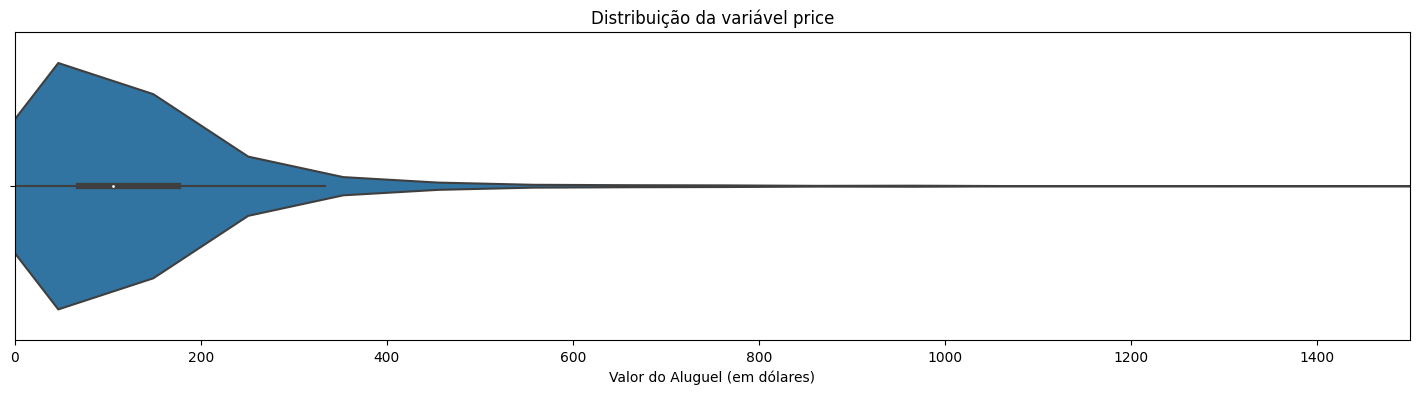

In [10]:
#Create a figure to plot
figure, ax = plt.subplots(figsize=(18,4))

#Create a violinplot
sns.violinplot(x=ny_rent['price'], ax=ax, )
ax.set_xlim(0, 1500)
plt.xlabel('Valor do Aluguel (em dólares)')
plt.title('Distribuição da variável price')

plt.show()


#### No gráfico acima conseguimos ver que boa parte dos valores está em um intervalo esperado, e que há alguns valores que são bem maiores. Calcularemos qual seria o valor máximo para esse conjunto de dados e ver o que está além desse valor.

In [11]:
#Define quantiles 1 and 3 and calculate IQR
q1_price = ny_rent['price'].quantile(.25)
q3_price = ny_rent['price'].quantile(.75)
IQR = q3_price - q1_price

#Set minimum and maximum price
min_price = q1_price - 1.5 * IQR
max_price = q3_price + 1.5 * IQR
print(f"Preço mínimo: US$ {min_price} \nPreço máximo: US$ {max_price}.")

Preço mínimo: US$ -90.0 
Preço máximo: US$ 334.0.


#### Usando a técnica de quartis e interquartil, conseguimos definir um valor mínimo de US$ −90,00 e um valor máximo de US$ 334,00 para nosso conjunto de dados, logicamente não consideramos o valor mínimo por ser negativo, apesar de termos 11 entradas com aluguel de US$ 0,00, acredito que seja um erro do host na hora de publicar o anúncio, portanto usaremos o valor mínimo de US$ 11,00. Por outro lado, tudo o que estiver acima de US$ 334,00 pode ser considerado como outlier.

In [12]:
print(f'Temos {ny_rent.query("price > 334.0").shape[0]} entradas que estão acima de 334 dólares. \
Pouco mais de 6% das entradas do nosso conjunto de dados.')

Temos 2972 entradas que estão acima de 334 dólares. Pouco mais de 6% das entradas do nosso conjunto de dados.


#### Essa quantidade de alugueis que estão acima de 334 dólares explica a diferença entre a média e a mediana da variável price. A média é 30% maior que a mediana.

In [13]:
#Outliers per neighborhood
ny_rent.query('price > 334.0').groupby('bairro_group')['bairro_group'].value_counts().sort_values(ascending=False)

bairro_group
Manhattan        2155
Brooklyn          689
Queens             99
Bronx              21
Staten Island       8
Name: count, dtype: int64

#### Como esperado, a maioria dos valores acima de US$ 334,00 está na ilha de Manhattan. A que mais aparece é Midtown, onde estão localizados os pontos mais famosos de Nova York. Porém, mesmo nessa área é possível encontrar aluguéis com valor abaixo de US$ 334,00 e que estão bem localizados. Em seguida, sem novidades também temos uma grande quantidade de imóveis acima do esperado no Brooklyn. Sendo as duas regiões que mais tem entradas no nosso conjunto de dados, faz sentido que tenham mais outliers também.

In [14]:
#Average price per neighborhood, properties above US$ 334
ny_rent.query('price < 334.0').groupby('bairro_group')['price'].median().sort_values()

bairro_group
Bronx             65.0
Queens            74.0
Staten Island     75.0
Brooklyn          90.0
Manhattan        135.0
Name: price, dtype: float64

#### Considerando a mediana, Manhattan é o bairro com o maior valor por imóvel. Mas devemos considerar outras variáveis para determinar se realmente é a melhor local para investir em imóvel para locação.

#### Vamos dar uma olhada na coluna ultima_review, ver quantos porcento a última review foi antes de 2019 e qual a porcentagem que obteve um review nos últimos 6 meses no dataset.

In [82]:
#Average ultima_review over 6 months ago and the last 6 months
six_months = ny_rent.query('ultima_review < "2019-01-01" and disponibilidade_365 != 0')['bairro_group'].value_counts().to_frame()\
   .reset_index()
six_months.rename(columns={'bairro_group': 'bairro_group', 'count': 'over_6_months'}, inplace=True)
neighborhoods = ['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island']
for n in neighborhoods:
   six_months.loc[six_months['bairro_group'] == n, 'last_6_months'] = ny_rent[(ny_rent['ultima_review'] >= '2019-01-01') \
                                 & (ny_rent['bairro_group'] == n) & (ny_rent['disponibilidade_365'] != 0)].shape[0]
   six_months.loc[six_months['bairro_group'] == n, 'total_original'] = ny_rent[ny_rent['bairro_group'] == n].shape[0]
   six_months.loc[six_months['bairro_group'] == n, 'total_missing(%)'] = round((ny_rent[ny_rent['bairro_group'] == n]\
                     ['ultima_review'].isnull().sum() / ny_rent[ny_rent['bairro_group'] == n].shape[0] * 100), 2)

six_months ['mean_over'] = round((six_months['over_6_months'] / six_months['total_original'] * 100), 2)
six_months ['mean_last'] = round((six_months['last_6_months'] / six_months['total_original'] * 100), 2)
six_months

,bairro_group,over_6_months,last_6_months,total_original,total_missing(%),mean_over,mean_last
0,Manhattan,1824,8989.0,21661.0,23.22,8.42,41.50
1,Brooklyn,1635,9028.0,20103.0,18.19,8.13,44.91
2,Queens,454,3181.0,5666.0,19.27,8.01,56.14
3,Bronx,87,669.0,1091.0,19.71,7.97,61.32
4,Staten Island,33,254.0,373.0,15.82,8.85,68.10


#### !

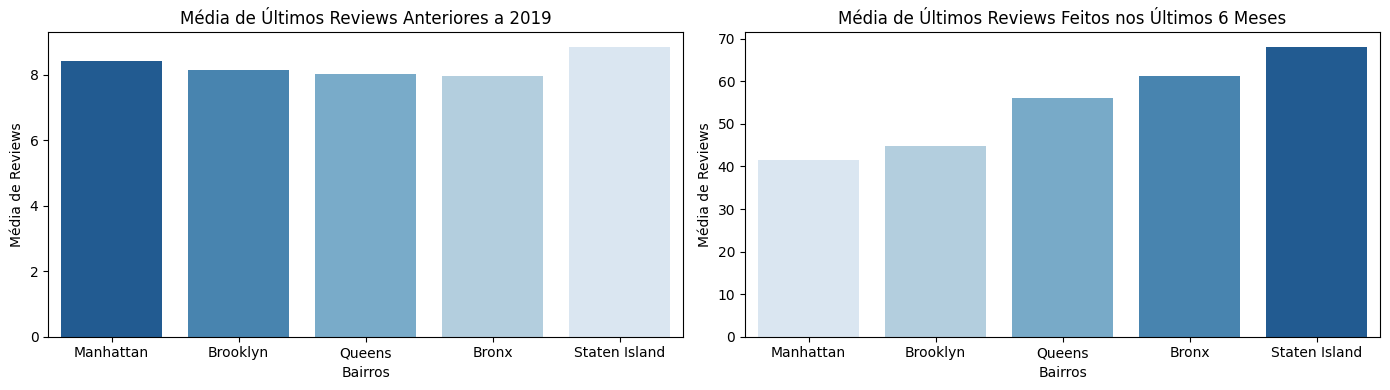

In [83]:
#Create a figure to plot
fig, axs =plt.subplots(ncols=2, figsize=(14,4))

#Plot 2 histograms
sns.barplot(x=six_months['bairro_group'], y=six_months['mean_over'], ax=axs[0], palette='Blues_r')
sns.barplot(x=six_months['bairro_group'], y=six_months['mean_last'], ax=axs[1], palette='Blues')
axs[0].set_xlabel('Bairros')
axs[0].set_ylabel('Média de Reviews')
axs[0].set_title('Média de Últimos Reviews Anteriores a 2019')

axs[1].set_xlabel('Bairros')
axs[1].set_ylabel('Média de Reviews')
axs[1].set_title('Média de Últimos Reviews Feitos nos Últimos 6 Meses')

plt.tight_layout();

#### No gráfico acima, o primeiro gráfico mostra que a média de últimos reviews que foram feitos antes de 2019 é praticamente igual em todos os bairros, porém quando olhamos para o segundo gráfico, que traz a média de últimos reviews dos últimos 6 meses, Staten Island é tem uma vantagem considerável sobre Manhattan e Brooklyn. Essa média foi calculada ignorando os imóveis que tem como disponibilidade de dias igual a 0, se não estão disponíveis para alugar, não tem como alguém fazer review por aluguel do apartamento.
#### Levando isso em consideração, já podemos pensar se realmente Manhattan é o local mais apropriado para investir em um imóvel.

#### Abaixo temos alguns aquivos json que armazenam a média do valor de compra de imóveis por bairro, esses valores foram tirados do site [Zillow]('https://www.zillow.com/home-values/102001/united-states/). Usaremos esses valores para calcular quais os bairros valem o investir em um imóvel.

In [223]:
#Read json files
def read_json(json_file):
    with open(json_file, 'r') as file:
        j_file = json.load(file)
    
    return j_file

In [231]:
#Json files containing the mean price per neighborhood
manhattan_mean_price = read_json('Json Files/manhattan_mean_price.json')
brooklyn_mean_price = read_json('Json Files/brooklyn_mean_price.json')
bronx_mean_price = read_json('Json Files/bronx_mean_price.json')
queens_mean_price = read_json('Json Files/queens_mean_price.json')
st_island_mean_price = read_json('Json Files/staten_island_mean_price.json')

#### Criei uma varíável para cada um dos grandes bairros de Nova York, Manhattan, Brooklyn, Bronx, Queens e State Island que estão armazenadas na variável bairro_group.
#### Para cada nova variável temos:
 * bairro
 * mediana de preço para aquele bairro no conjuto de dados
 * mediana de preço de compra de imóveis obtidas dos arquivos json, 
 * qual o valor esperado por diária para poder considerarmos o imóvel rentável
 * lucro, calculado subtraindo o valor esperado do preço
 #### Uma das regras levada em consideração para calcular se devemos ou não investir em um imóvel seria obter um aluguel mensal de 1% do valor pago pelo imóvel, contudo, nosso intuito aqui é alugar considerando a diária, portanto esse valor foi dividido por 30 e assim temos uma média do valor que deveria ser cobrado por dia para que o imóvel se torne um investimento atrativo.

In [371]:
#Create a list of 
manhattan = round(ny_rent.query('bairro_group == "Manhattan" and disponibilidade_365 != 0 and room_type == "Entire home/apt"')\
                  .groupby('bairro')['price'].median(), 2).sort_values().to_frame().reset_index()
manhattan['média_preço_compra(US$)'] = manhattan['bairro'].map(manhattan_mean_price)
manhattan['1%'] = round(manhattan['média_preço_compra(US$)'] * 0.01 / 30, 2)
manhattan['lucro'] = manhattan['price'] - manhattan['1%']

brooklyn = round(ny_rent.query('bairro_group == "Brooklyn" and disponibilidade_365 != 0 and room_type == "Entire home/apt"')\
                 .groupby('bairro')['price'].median(), 2).sort_values().to_frame().reset_index()
brooklyn['média_preço_compra(US$)'] = brooklyn['bairro'].map(brooklyn_mean_price)
brooklyn['1%'] = round(brooklyn['média_preço_compra(US$)'] * 0.01 / 30, 2)
brooklyn['lucro'] = brooklyn['price'] - brooklyn['1%']

bronx = round(ny_rent.query('bairro_group == "Bronx" and disponibilidade_365 != 0 and room_type == "Entire home/apt"')\
              .groupby('bairro')['price'].median(), 2).sort_values().to_frame().reset_index()
bronx['média_preço_compra(US$)'] = bronx['bairro'].map(bronx_mean_price)
bronx['1%'] = round(bronx['média_preço_compra(US$)'] * 0.01 / 30, 2)
bronx['lucro'] = bronx['price'] - bronx['1%']

queens = round(ny_rent.query('bairro_group == "Queens" and disponibilidade_365 != 0 and room_type == "Entire home/apt"')\
               .groupby('bairro')['price'].median(), 2).sort_values().to_frame().reset_index()
queens['média_preço_compra(US$)'] = queens['bairro'].map(queens_mean_price)
queens['1%'] = round(queens['média_preço_compra(US$)'] * 0.01 / 30, 2)
queens['lucro'] = queens['price'] - queens['1%']

st_island = round(ny_rent.query('bairro_group == "Staten Island" and disponibilidade_365 != 0 and room_type == "Entire home/apt"')\
                  .groupby('bairro')['price'].median(), 2).sort_values().to_frame().reset_index()
st_island['média_preço_compra(US$)'] = st_island['bairro'].map(st_island_mean_price)
st_island['1%'] = round(st_island['média_preço_compra(US$)'] * 0.01 / 30, 2)
st_island['lucro'] = st_island['price'] - st_island['1%']

#### Vamos verificar quais bairros em cada grande bairro tem o valor da coluna price maior do que o valor que calculamos de 1%.

In [372]:
#Where a rental property is profitable
print(manhattan[manhattan['price'] > manhattan['1%']], '\n')
print(brooklyn[brooklyn['price'] > brooklyn['1%']], '\n')
print(bronx[bronx['price'] > bronx['1%']], '\n')
print(queens[queens['price'] > queens['1%']], '\n')
print(st_island[st_island['price'] > st_island['1%']], '\n')

Empty DataFrame
Columns: [bairro, price, média_preço_compra(US$), 1%, lucro]
Index: [] 

          bairro  price  média_preço_compra(US$)      1%  lucro
45  Vinegar Hill  200.0                   451434  150.48  49.52 

               bairro  price  média_preço_compra(US$)      1%  lucro
3          Highbridge   76.0                   219741   73.25   2.75
9         Parkchester   88.0                   205543   68.51  19.49
17        Kingsbridge   99.0                   291734   97.24   1.76
25         Mount Hope  105.0                   250944   83.65  21.35
31  Concourse Village  115.0                   304945  101.65  13.35
34          Riverdale  124.5                   362119  120.71   3.79
37            Norwood  125.0                   366919  122.31   2.69
41         West Farms  165.0                   439582  146.53  18.47
42        Eastchester  202.5                   545861  181.95  20.55
43            Belmont  247.0                   470459  156.82  90.18 

           bairro  p

#### Levando o calculo acima, vemos que Manhattan, apesar de ter os valores mais altos, não é o local mais indicado para comprar um imóvel devido ao alto valor de compra dos mesmos, tanto que não tem nenhum bairro que tenha o valor na coluna price que seja maior que o valor calculado de 1%. 
#### Bronx é a área onde a maior quantidade de bairros com imóveis rentáveis.

In [373]:
#Concat all the neighborhoods and profits
buroughs = [manhattan[manhattan['price'] > manhattan['1%']][['bairro', 'lucro']], 
            brooklyn[brooklyn['price'] > brooklyn['1%']][['bairro', 'lucro']], 
            bronx[bronx['price'] > bronx['1%']][['bairro', 'lucro']], queens[queens['price'] > queens['1%']][['bairro', 'lucro']], 
            st_island[st_island['price'] > st_island['1%']][['bairro', 'lucro']]]

new_york = pd.concat(buroughs)

In [374]:
#From less to more profitable
print("Ranking de bairro de acordo com o lucro oferecido.")
new_york.sort_values(by='lucro')

,bairro,lucro
31,Kew Gardens,1.56
17,Kingsbridge,1.76
37,Norwood,2.69
3,Highbridge,2.75
34,Riverdale,3.79
48,Jamaica Hills,5.95
31,Concourse Village,13.35
41,West Farms,18.47
9,Parkchester,19.49
42,Eastchester,20.55


#### Acima temos um ranking do lucro diário de cada bairro.

#### Comparando os bairros acima com o dataset, segue ranking de melhores oportunidades. Aqui consideramos o aluguel do imóvel como todo ou um imóvel com pelo menos 3 dormitórios para alugar por quarto.
<table>
* Parkchester (31,31) - Bronx - US$ 19.49
* Vinegar Hill (21,21) - Brooklyn - US$ 49.52
* Mount Hope (16,16) - Bronx - US$ 21.35
* Concourse Village(24, 24) - Bronx - US$ 13.35
* Riverdale (8,8) - Bronx - US$ 3.79
* Kingsbridge (58,58) - Bronx - US$ 1.76
</table>
<table>
* Belmont (9, 17) - Bronx - US$ 90.18
* Jamaica Hills (4, 6) - Queens - US$ 5.95
* Highbridge (22, 24) - Bronx - US$ 2.75
* Norwood (19,21) - Bronx - US$ 2.69
* Eastchester (11, 13) - Bronx - US$ 20.55
* West Farms (2,2) - Bronx - US$ 18.47
* Kew Gardens(50, 58) - Queens - US$ 1.56
</table>



https://smartasset.com/taxes/new-york-property-tax-calculator#:~:text=When%20taking%20those%20exemptions%20into,%2C%20the%20rate%20is%200.98%25.